<a href="https://colab.research.google.com/github/pranavrelds/pranavrelds-Anomaly-Detection-for-Steel-Defects/blob/main/Steel_Defect_Detection_Solution_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Libraries

In [2]:
!pip install --quiet vit-keras
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 10.6MB/s 


In [31]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from vit_keras import vit
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score,confusion_matrix, auc, roc_curve, classification_report

%cd /content/drive/MyDrive/Steel Defect Detection and Localization
from utilities import rle2mask,mask2rle, DataGenerator, dice_coef,dice_loss

/content/drive/MyDrive/Steel Defect Detection and Localization


# Configurations

In [136]:
DIR = '/content/drive/MyDrive/Steel Defect Detection and Localization/'
TRAINING_IMAGES = '/content/drive/MyDrive/Steel Defect Detection and Localization/train_images'
TEST_IMAGES = '/content/drive/MyDrive/Steel Defect Detection and Localization/test_images'

learning_rate_clf = 1e-4
CLASSIFICATION_MODEL_EPOCH = 25
CLASSIFICATION_MODEL_PATIENCE = 20
CLASSIFICATION_MODEL_IMAGE_SIZE = 256
CLASSIFICATION_MODEL_BATCH_SIZE = 16
CLASSIFICATION_MODEL_PATH = '/content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFICATION/clf_model_vit.hdf5'
CLASSIFICATION_MODEL_ARC = '/content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFICATION/clf_model_vit_architecture.json'

SEGMENTATION_MODEL_IMAGE_SIZE = 256

# Class 1 Model
SEGMENTATION_MODEL_C1_EPOCH = 6
SEGMENTATION_MODEL_C1_PATIENCE = 4
SEGMENTATION_MODEL_C1_PATH = '/content/drive/MyDrive/Steel Defect Detection and Localization/class_1_segmentation/ResUNet-segmentation-weights_class_1.hdf5'

# Class 2 Model
SEGMENTATION_MODEL_C2_EPOCH = 30
SEGMENTATION_MODEL_C2_PATIENCE = 25
SEGMENTATION_MODEL_C2_PATH = '/content/drive/MyDrive/Steel Defect Detection and Localization/class_2_segmentation/ResUNet-segmentation-weights_class_2.hdf5'

# Class 3 Model
SEGMENTATION_MODEL_C3_EPOCH = 12
SEGMENTATION_MODEL_C3_PATIENCE = 10
SEGMENTATION_MODEL_C3_PATH = '/content/drive/MyDrive/Steel Defect Detection and Localization/class_3_segmentation/ResUNet-segmentation-weights_class_3.hdf5'

# Class 4 Model
SEGMENTATION_MODEL_C4_EPOCH = 8
SEGMENTATION_MODEL_C4_PATIENCE = 6
SEGMENTATION_MODEL_C4_PATH = '/content/drive/MyDrive/Steel Defect Detection and Localization/class_4_segmentation/ResUNet-segmentation-weights_class_4.hdf5'


# Load Data
DF_TRAIN = pd.read_csv(DIR+'train.csv')
DF_ALL = pd.read_csv(DIR+'all_images_df.csv')

# Load Data

In [ ]:
DF_TRAIN = pd.read_csv(DIR+'train.csv')
DF_TRAIN.head(5) 

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
# Creating a dataframe of Test Images
test_images = []
for i in os.listdir(TEST_IMAGES):
  if i not in test_images:
    test_images.append(i)

DF_TEST = pd.DataFrame(test_images, columns=['ImageId'])
# Saving data as csv file
DF_TEST.to_csv(DIR+'test.csv', index=False)

# Seperate Images with defect from non-defect images

In [ ]:
# Unique images in the dataframe
defect = DF_TRAIN['ImageId'].unique()
# Images from training directory which are not in the DF_TRAIN
defect_images = []
for i in os.listdir(TRAINING_IMAGES):
  if i not in defect_images:
    if i in defect.tolist():
      defect_images.append([i,1])
    else:
      defect_images.append([i,0])

image_id = pd.DataFrame(list(map(lambda x:x[0],defect_images)),columns=['ImageId'])
defect_present = pd.DataFrame(list(map(lambda x:x[1],defect_images)),columns=['defect_present'])
ALL_IMAGES_DF = pd.concat([image_id,defect_present],axis=1)
ALL_IMAGES_DF.head(5)

,ImageId,defect_present
0,e83d27de8.jpg,1
1,ea23dae53.jpg,1
2,e9eb5a464.jpg,0
3,e9c4686f0.jpg,1
4,e8a04b4f8.jpg,1


In [ ]:
# save dataframe
ALL_IMAGES_DF.to_csv('/content/drive/MyDrive/Steel Defect Detection and Localization/all_images_df.csv', index=False)

# EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


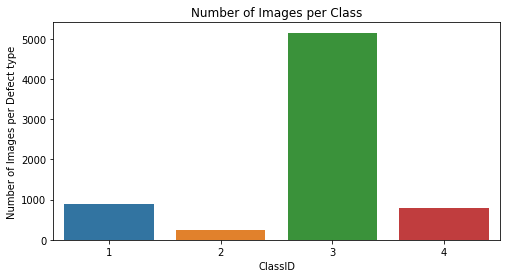

In [ ]:
# Number of datapoints/images per Class
plt.figure(figsize=(8,4))
sns.countplot(DF_TRAIN['ClassId'])
plt.xlabel('ClassID')
plt.ylabel('Number of Images per Defect type')
plt.title('Number of Images per Class')
plt.show()

 **Observation:**

This dataset is **imbalanced** as the number of images with ClassId 3 are much much more than the other ClassId

In [ ]:
DF_EDA = DF_TRAIN.copy()
DF_EDA['defect_present'] = DF_EDA['ClassId'].map(lambda x:1)

In [ ]:
# Some images are classified with more than one defect,

defect_type = DF_EDA.groupby(['ImageId'])['defect_present'].sum()
defect_type.value_counts()

1    6239
2     425
3       2
Name: defect_present, dtype: int64

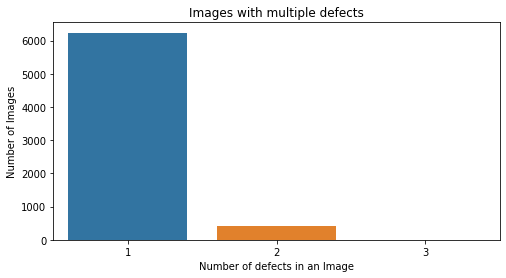

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts())
plt.xlabel('Number of defects in an Image')
plt.ylabel('Number of Images')
plt.title('Images with multiple defects')
plt.show()

**Observation:**



*    There are only 2 image with 3 types of defects 
*    There are 425 images with 2 types of defects
*    There are 6239 images with 1 type of defect

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


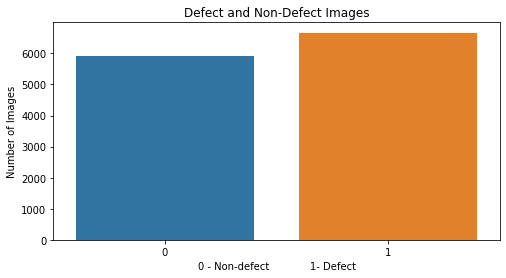

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(ALL_IMAGES_DF['defect_present'])
plt.ylabel('Number of Images')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and Non-Defect Images')
plt.show()

In [ ]:
ALL_IMAGES_DF['defect_present'].value_counts()

1    6666
0    5902
Name: defect_present, dtype: int64

## Visualizing the Images

In [ ]:
%cd /content/drive/MyDrive/Steel Defect Detection and Localization
from utilities import rle2mask, mask2rle
train_images_dir = '/content/drive/MyDrive/Steel Defect Detection and Localization/train_images'

/content/drive/MyDrive/Steel Defect Detection and Localization


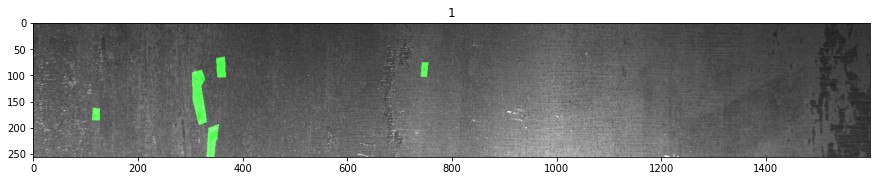

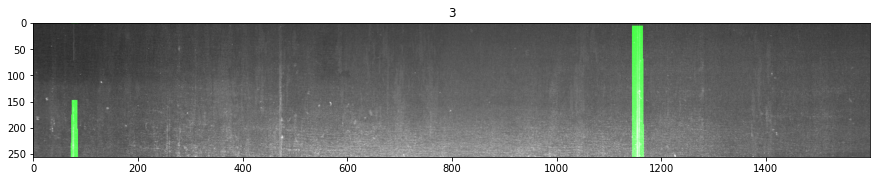

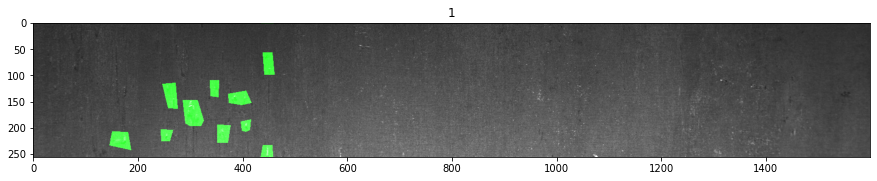

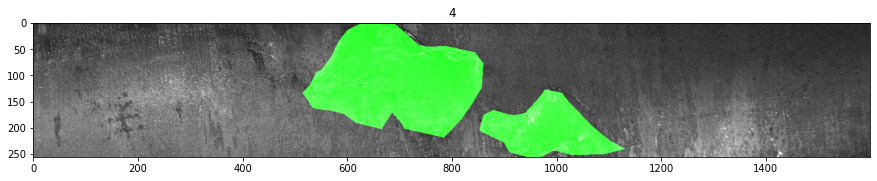

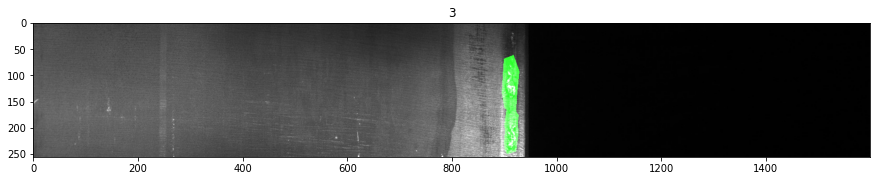

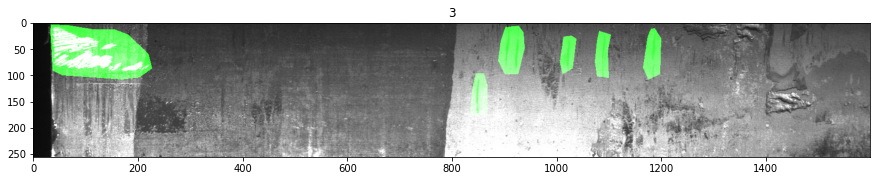

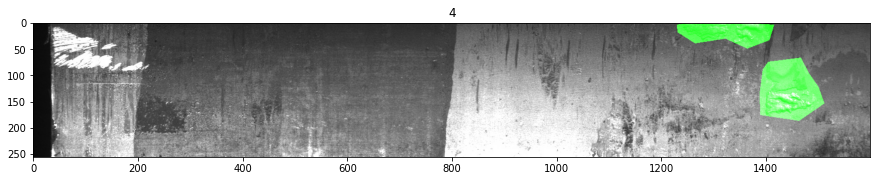

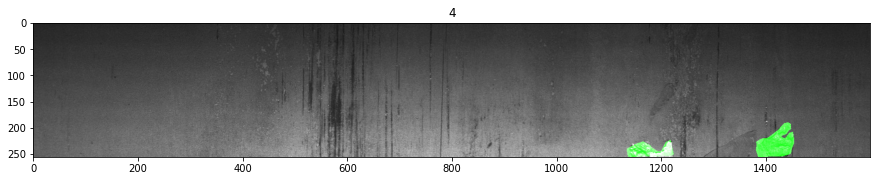

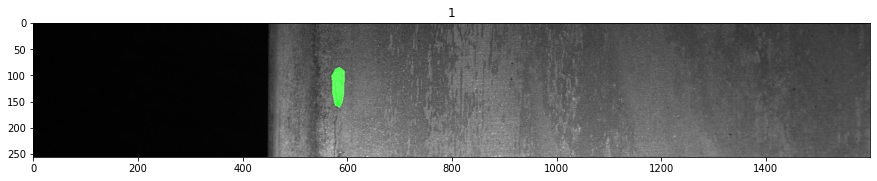

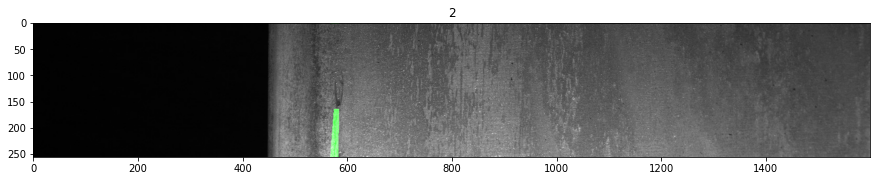

In [ ]:
for i in range(10):
  image = io.imread(os.path.join(train_images_dir, train_df['ImageId'][i]))

  # Convert the images to RGB format using openCV
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # mask on the image using rle2mask
  mask = rle2mask(rle = train_df['EncodedPixels'][i], height= image.shape[0], width= image.shape[1])

  #Color mask pixel with value 1 
  image[mask == 1,1] = 255 # making mask green

  #Show the image
  plt.figure(figsize=(15,5))
  plt.title(train_df['ClassId'][i])
  plt.imshow(image)


In [ ]:
print('The size of image is : ', mask.shape[0],'x',mask.shape[1],'\n')

The size of image is :  256 x 1600 



In [ ]:
def get_rle_sum_plot(df, class_id):
  rle_sum = []
  for i in range(len(df)):
    if df['ClassId'][i]==class_id:
      splitted_rle = df['EncodedPixels'][i].split(' ')[1::2]
      count = 0
      for j in splitted_rle:
        count = count + int(j)
      rle_sum.append(count)
    else:
      rle_sum.append(0)
  column_name = 'rle_sum_'+str(class_id)
  df[column_name] = rle_sum
  temp = df[df[column_name]!=0][column_name]
  plt.figure(figsize=(8,4))
  sns.distplot(temp, fill=True)
  plt.show()

In [ ]:
def get_rle_sum_percentile(df, column_name):
  print('Mean = ' ,df[column_name].mean())
  for i in range(0,100,25):
    temp = df[df[column_name]!=0][column_name]
    sorted = np.sort(temp,axis = None)
    percentile = sorted[int(len(sorted)*(float(i)/100))]
    print("{}th percentile = {}".format(i,percentile))
    percentile_99 = sorted[int(len(sorted)*(float(99)/100))]
  print("99th percentile = ", percentile_99)
  print("100th percentile = ",sorted[-1])
  

In [ ]:
# making a copy of original dataframe
df = train_df.copy()

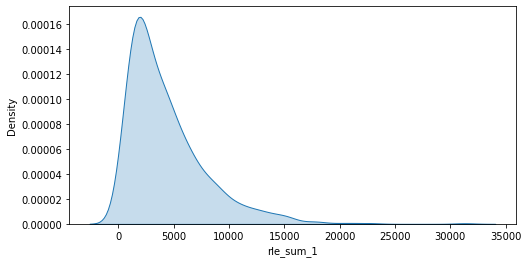

Mean =  551.3923890063425
0th percentile = 163
25th percentile = 1762
50th percentile = 3326
75th percentile = 5795
99th percentile =  15689
100th percentile =  31303


In [ ]:
get_rle_sum_plot(df=df, class_id=1)
get_rle_sum_percentile(df, column_name='rle_sum_1')

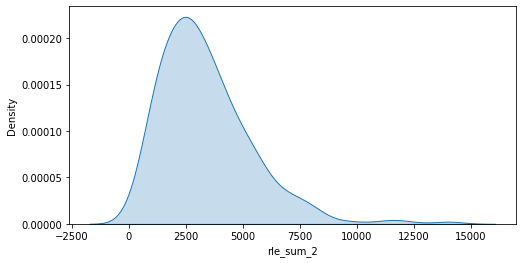

Mean =  117.61395348837209
0th percentile = 316
25th percentile = 1947
50th percentile = 2944
75th percentile = 4439
99th percentile =  11302
100th percentile =  14023


In [ ]:
get_rle_sum_plot(df=df, class_id=2)
get_rle_sum_percentile(df, column_name='rle_sum_2')

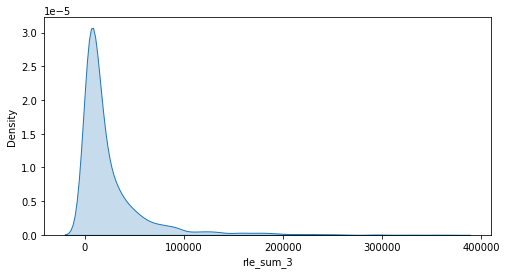

Mean =  18506.96250880902
0th percentile = 115
25th percentile = 5054
50th percentile = 11960
75th percentile = 29034
99th percentile =  193938
100th percentile =  368240


In [ ]:
get_rle_sum_plot(df=df, class_id=3)
get_rle_sum_percentile(df, column_name='rle_sum_3')

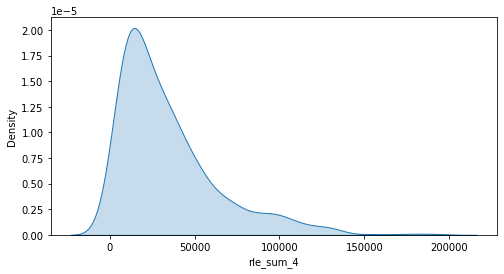

Mean =  3880.7007751937986
0th percentile = 491
25th percentile = 13114
50th percentile = 25357
75th percentile = 45221
99th percentile =  129924
100th percentile =  192780


In [ ]:
get_rle_sum_plot(df=df, class_id=4)
get_rle_sum_percentile(df, column_name='rle_sum_4')

**Observations:**



*    For Defect 1, sum of encoding ranges from 163 to 31303
*    For Defect 2, sum of encoding ranges from 316 to 14023
*    For Defect 3, sum of encoding ranges from 115 to 368240
*    For Defect 4, sum of encoding ranges from 419 to 192780
*    All values have a sudden increase after 99th percentile

**Observation:**



*    For Defect 2, sum of encoding ranges from 316 to 14023

In [ ]:
def get_rle_sum_percentile(df, column_name):
  for i in range(0,100,25):
    temp = df[df[column_name]!=0][column_name]
    sorted = np.sort(temp,axis = None)
    percentile = sorted[int(len(sorted)*(float(i)/100))]
    print("{}th percentile = {}".format(i,percentile))
  print("100th percentile = ",sorted[-1])

In [ ]:
get_rle_sum_percentile(df, 'rle_sum_2')

0th percentile = 316
25th percentile = 1947
50th percentile = 2944
75th percentile = 4439
100th percentile =  14023


# Classification of Defects using Vision Transformers

## Functions

In [44]:
def get_history_plot(history, metric_string):
  # summarize history for accuracy
  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  plt.plot(history.history[metric_string])
  plt.plot(history.history['val_'+ metric_string])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

## Splitting data into Train, Test and Validation sets

In [8]:
# Images with no defect
DF_NO_DEFECT = DF_ALL[DF_ALL['defect_present']==0]
DF_NO_DEFECT = DF_NO_DEFECT.rename(columns={'ImageId':'ImageId', 'defect_present':'ClassId'})

DF_COPY = DF_TRAIN[['ImageId','ClassId']]
# Concatenate dafarames with defect and no defect
DF_COPY = pd.concat([DF_COPY, DF_NO_DEFECT])

# Creating Dummy variables for ClassId
DUMMY =  pd.get_dummies(data = DF_COPY['ClassId'], prefix='Defect_Type')

# Concatenate DUMMY with DF_COPY 
DF_COPY =  pd.concat([DF_COPY, DUMMY], axis=1)
DF_COPY.to_csv(DIR+'df_defect_no_defect.csv', index = False)

In [9]:
# Splitting into Train and Test sets
X_train_ml, X_test_ml = train_test_split(DF_COPY, test_size = 0.15,stratify = DF_COPY['ClassId'] ,random_state=0)
print('Number of images in Training set : ',X_train_ml.shape[0])
print('Number of images in Test set : ', X_test_ml.shape[0])

Number of images in Training set :  11047
Number of images in Test set :  1950


## Image Data Generator with Augmentation for Train, Test and Validation sets

In [16]:
def augmentaion(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [17]:
columns = ['Defect_Type_0', 'Defect_Type_1', 'Defect_Type_2', 'Defect_Type_3', 'Defect_Type_4']

datagen = ImageDataGenerator(rescale = 1./255,
                             samplewise_center = True,
                             samplewise_std_normalization = True,
                             validation_split = 0.2,
                             preprocessing_function = augmentaion
                             )

train_generator = datagen.flow_from_dataframe(
                                        dataframe = X_train_ml,
                                        directory = TRAINING_IMAGES,
                                        x_col = 'ImageId',
                                        y_col = columns,
                                        subset = 'training',
                                        batch_size = CLASSIFICATION_MODEL_BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'raw',
                                        target_size = (CLASSIFICATION_MODEL_IMAGE_SIZE, CLASSIFICATION_MODEL_IMAGE_SIZE)
                                        )

valid_generator = datagen.flow_from_dataframe(
                                        dataframe = X_train_ml,
                                        directory = TRAINING_IMAGES,
                                        x_col = 'ImageId',
                                        y_col = columns,
                                        subset = 'validation',
                                        batch_size = CLASSIFICATION_MODEL_BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'raw',
                                        target_size = (CLASSIFICATION_MODEL_IMAGE_SIZE, CLASSIFICATION_MODEL_IMAGE_SIZE)
                                        )

test_generator  = datagen.flow_from_dataframe(
                                       dataframe = X_test_ml,
                                       directory = TRAINING_IMAGES,
                                       x_col = 'ImageId',
                                       y_col = None,
                                       batch_size = CLASSIFICATION_MODEL_BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (CLASSIFICATION_MODEL_IMAGE_SIZE, CLASSIFICATION_MODEL_IMAGE_SIZE)
                                       )

# Step size for model fitting
STEP_SIZE_TRAIN = train_generator .n // train_generator .batch_size
STEP_SIZE_VALID = valid_generator .n // valid_generator .batch_size

Found 8838 validated image filenames.
Found 2209 validated image filenames.
Found 1950 validated image filenames.


## Model

In [12]:
vit_model = vit.vit_b32(
        image_size = CLASSIFICATION_MODEL_IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

353255424/353253686 [==============================] - 4s 0us/step


In [18]:
model_clf = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation = tf.keras.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(8, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')],
        name = 'vision_transformer')

model_clf.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87466752  
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 768)               3072      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                12304     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)          

In [19]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate_clf)

model_clf.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = CLASSIFICATION_MODEL_PATIENCE,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = CLASSIFICATION_MODEL_PATH,
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

history_clf = model_clf.fit(x = train_generator ,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_generator ,
                        validation_steps = STEP_SIZE_VALID,
                        epochs = CLASSIFICATION_MODEL_EPOCH,
                        callbacks = callbacks)

Epoch 1/25
552/552 [==============================] - 3052s 5s/step - loss: 1.5497 - accuracy: 0.4212 - val_loss: 1.2328 - val_accuracy: 0.6662

Epoch 00001: val_accuracy improved from -inf to 0.66621, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFICATION/clf_model_vit.hdf5
Epoch 2/25
552/552 [==============================] - 274s 496ms/step - loss: 1.3604 - accuracy: 0.5755 - val_loss: 1.2322 - val_accuracy: 0.6689

Epoch 00002: val_accuracy improved from 0.66621 to 0.66893, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFICATION/clf_model_vit.hdf5
Epoch 3/25
552/552 [==============================] - 273s 495ms/step - loss: 1.2472 - accuracy: 0.6696 - val_loss: 1.1118 - val_accuracy: 0.7622

Epoch 00003: val_accuracy improved from 0.66893 to 0.76223, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFICATION/clf_model_vit.hdf5
Epoch 4/25
552/552 [=========================

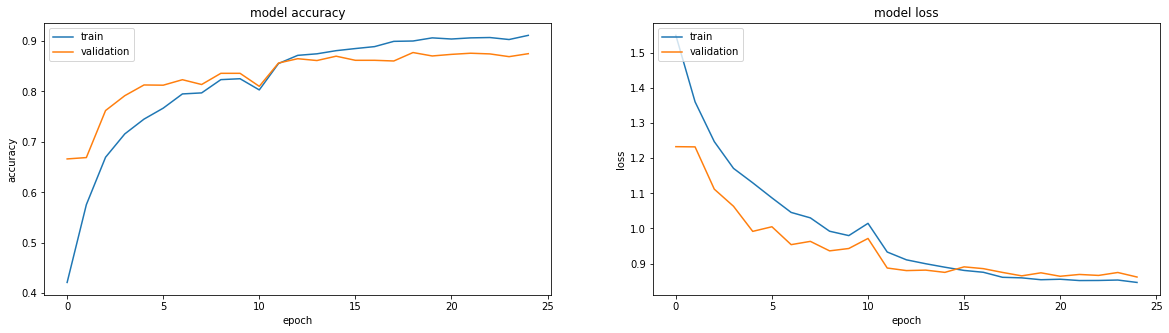

In [24]:
get_history_plot(history_clf, metric_string = 'accuracy')

## Prediction

In [26]:
y_pred = np.argmax(model_clf.predict_generator(generator=test_generator ,
                                                      steps=test_generator.n//test_generator.batch_size+1,
                                                      verbose=1), axis = 1)

122/122 [==============================] - 568s 5s/step


              precision    recall  f1-score   support

           0       0.91      0.95      0.93       885
           1       0.77      0.64      0.70       135
           2       0.61      0.59      0.60        37
           3       0.89      0.84      0.86       773
           4       0.65      0.75      0.70       120

    accuracy                           0.87      1950
   macro avg       0.76      0.75      0.76      1950
weighted avg       0.87      0.87      0.87      1950



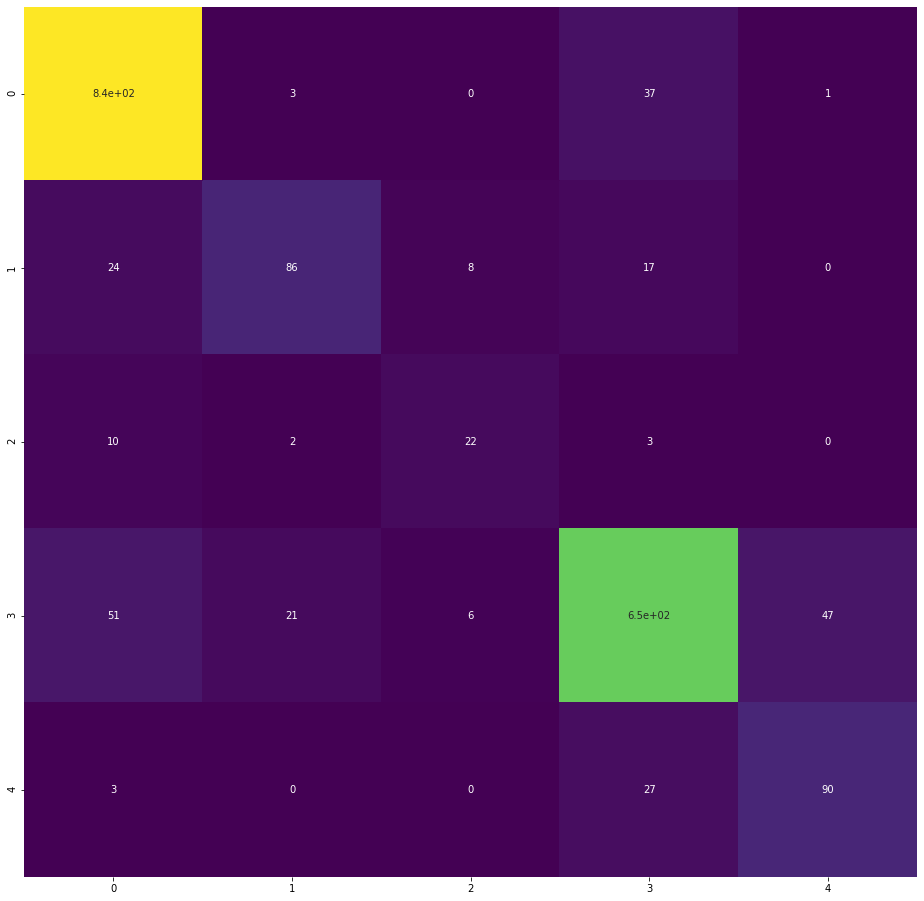

In [32]:
y_true = np.asarray(X_test_ml.ClassId)  

confusionmatrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'viridis', annot = True, cbar = False)

print(classification_report(y_true, y_pred))

**Observation :**

* Recall rate for class 1 is low
* f1-score for class 2 is low 

# Segmentation of Images using ResUNet - 4 Models

## ResUNet Architecture

In [52]:
# model architecture (https://arxiv.org/pdf/1904.00592.pdf)
def resblock(X, f):
  

  # making a copy of input
  X_copy = X

  # main path
  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

# function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

input_shape = (SEGMENTATION_MODEL_IMAGE_SIZE,SEGMENTATION_MODEL_IMAGE_SIZE,1)

def get_segmentation_model():
  #Input tensor shape
  X_input = Input(input_shape)

  #Stage 1
  conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
  conv1_in = BatchNormalization()(conv1_in)
  conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
  conv1_in = BatchNormalization()(conv1_in)
  pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

  #Stage 2
  conv2_in = resblock(pool_1, 32)
  pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

  #Stage 3
  conv3_in = resblock(pool_2, 64)
  pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

  #Stage 4
  conv4_in = resblock(pool_3, 128)
  pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

  #Stage 5
  conv5_in = resblock(pool_4, 256)

  #Upscale stage 1
  up_1 = upsample_concat(conv5_in, conv4_in)
  up_1 = resblock(up_1, 128)

  #Upscale stage 2
  up_2 = upsample_concat(up_1, conv3_in)
  up_2 = resblock(up_2, 64)

  #Upscale stage 3
  up_3 = upsample_concat(up_2, conv2_in)
  up_3 = resblock(up_3, 32)

  #Upscale stage 4
  up_4 = upsample_concat(up_3, conv1_in)
  up_4 = resblock(up_4, 16)

  #Final Output
  output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

  model_seg = Model(inputs = X_input, outputs = output)
  return model_seg

## Functions

In [34]:
def get_X_train_test_val(df, class_id):
  """
    returns train, test and validation sets with respect to ClassId
    
  """

  class_df = df[df['ClassId'] == class_id]
  X_train, X_test = train_test_split(class_df, test_size=0.12,random_state=0)
  X_train, X_val = train_test_split(X_train, test_size=0.12, random_state=0)
  print('Number of images in train data : ',X_train.shape[0])
  print('Number of images in test data : ', X_test.shape[0])
  print('Number of images in validation data : ', X_val.shape[0])
  return X_train, X_test, X_val

In [78]:

def predict_mask(X_test, model_seg, image_path):

  #Creating empty list to store the results
  mask = []
  defect_type = []
  image_id = []
  c = X_test.ClassId[0] 
  j = c - 1
  #iterating through each image datafra
  for i in X_test.ImageId:
    path = os.path.join(image_path, i)

    #reading the image
    img = io.imread(path)       
    
    #reading the image along blue channel (0)
    img =img[:,:,0]

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 1))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256 to 1,256,256,1
    X[0,] = np.expand_dims(img, axis = 2)

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no defect
    if predict.round().astype(int).sum() == 0:
      image_id.append(i)
      defect_type.append(0)
      mask.append('0 0')
      continue
  
    mask_value = predict[0,:,:,j].round().astype(int)

      #if the sum of mask values is greater than 0.5(anything greater than 0 ), that class has defect
    if mask_value.sum() > 0.5:
      try:
          #applying mask to image, area with defect will be highlighted in white(255)
          img[mask_value == 1] = 255
          #since original shape is 256,1600, reshape to that size
          img = cv2.resize(img,(1600,256))
          #Now, mask the image such that, areas which are not white(defected areas) to be black(0)
          img[img < 255] = 0
          #again normalize the values
          img = img * 1./255.
          #get the rle for the create masked image
          rle = mask2rle(img)
      except:
          continue

      #append the valeues to the respective listes
      image_id.append(i)
      defect_type.append(c)
      mask.append(rle)

  return image_id, defect_type, mask

In [36]:
def load_model(model_path):
  # load the segmentation model with custom loss function
  model=tf.keras.models.load_model(filepath=model_path, custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef}) 
  model.compile(optimizer='adam',loss=dice_loss,metrics=[dice_coef])
  return model

In [61]:
def show_original_pred_mask(images_path, X_test, df_pred, no_of_images_to_print):
  # iterating over images
  for i in range(no_of_images_to_print+1):
    # read the images
    img0 = io.imread(os.path.join(images_path, X_test['ImageId'][i]))
    img1 = io.imread(os.path.join(images_path, df_pred['ImageId'][i]))
    # convert to rgb format
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    # Get mask from the encodings
    mask0 = rle2mask(rle = X_test['EncodedPixels'][i], height= img0.shape[0], width= img0.shape[1])
    mask1 = rle2mask(rle = df_pred['EncodedPixels'][i], height= img1.shape[0], width= img1.shape[1])
    # original mask in green
    img0[mask0 == 1,1] = 255
    # predicted mask in red
    img1[mask1 == 1,0] = 255
    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plt.imshow(img0)
    plt.title('Original Mask - Defect Class %s' % X_test['ClassId'][i])
    plt.subplot(122)
    plt.imshow(img1)
    plt.title('Predicted Mask - Defect Class %s' % df_pred['ClassId'][i])
    plt.show()

In [55]:
def training(X_train, X_val, images_dir_path, weights_save_path, earlystopping_patience, lr,epochs, epsilon= 1e-07):
  """
  returns trained model and its history 

  """
  train_ids = list(X_train.ImageId)
  train_class = list(X_train.ClassId)
  train_rle = list(X_train.EncodedPixels)

  val_ids = list(X_val.ImageId)
  val_class = list(X_val.ClassId)
  val_rle = list(X_val.EncodedPixels)

  # Custom data generator 
  training_generator = DataGenerator(train_ids,train_class, train_rle, images_dir_path)
  validation_generator= DataGenerator(val_ids,val_class,val_rle, images_dir_path)

  model = get_segmentation_model()
  # optimizer
  adam = tf.keras.optimizers.Adam(learning_rate = lr, epsilon = epsilon ) 
  model.compile(optimizer = 'adam', loss = dice_loss, metrics = [dice_coef])

  # using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
  earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=earlystopping_patience)

  # save the best model with lower validation loss
  checkpointer = ModelCheckpoint(filepath= weights_save_path, verbose=1, save_best_only=True)

  history = model.fit(training_generator,
                              epochs = epochs,
                              validation_data= validation_generator,
                              callbacks=[checkpointer, earlystopping])
  return model, history

## Class 1 images training

In [40]:
# Training, test and validations sets
X_train, X_test, X_val = get_X_train_test_val(DF_TRAIN, class_id=1)

Number of images in train data :  694
Number of images in test data :  108
Number of images in validation data :  95


In [56]:
# Model training 
model_c1, history_c1 = training(X_train = X_train,
                                X_val= X_val,
                                images_dir_path= TRAINING_IMAGES,
                                weights_save_path = SEGMENTATION_MODEL_C1_PATH,
                                earlystopping_patience = SEGMENTATION_MODEL_C1_PATIENCE,
                                lr = 0.001,
                                epochs = SEGMENTATION_MODEL_C1_EPOCH)

Epoch 1/8
43/43 [==============================] - 18s 333ms/step - loss: 0.9882 - dice_coef: 0.0118 - val_loss: 0.9898 - val_dice_coef: 0.0102

Epoch 00001: val_loss improved from inf to 0.98982, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_1_segmentation/ResUNet-segmentation-weights_class_1.hdf5
Epoch 2/8
43/43 [==============================] - 13s 312ms/step - loss: 0.9808 - dice_coef: 0.0192 - val_loss: 0.9854 - val_dice_coef: 0.0146

Epoch 00002: val_loss improved from 0.98982 to 0.98542, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_1_segmentation/ResUNet-segmentation-weights_class_1.hdf5
Epoch 3/8
43/43 [==============================] - 14s 313ms/step - loss: 0.9690 - dice_coef: 0.0310 - val_loss: 0.9830 - val_dice_coef: 0.0170

Epoch 00003: val_loss improved from 0.98542 to 0.98302, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_1_segmentation/ResUNet-segmentat

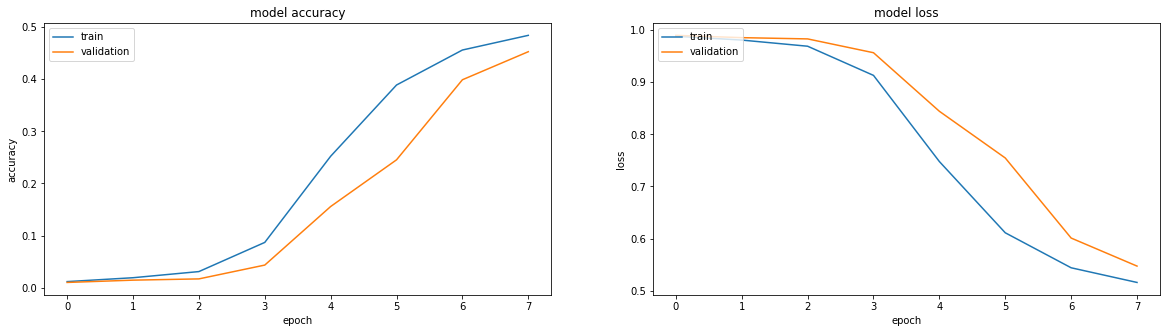

In [57]:
get_history_plot(history_c1, 'dice_coef')

In [59]:
X_test.reset_index(inplace=True)
# get prediction
image_id, defect_type, mask = predict_mask(X_test, model_c1, TRAINING_IMAGES)
# create a dataframe of the predictions
df_pred_1= pd.DataFrame({'ImageId': image_id,'ClassId': defect_type, 'EncodedPixels': mask})
df_pred_1.head()

,ImageId,ClassId,EncodedPixels
0,26c156283.jpg,1,221842 2 222098 2 222354 2 222610 2 222866 2 2...
1,0fd63823c.jpg,1,108180 4 108436 4 108692 4 108948 4 109204 4 1...
2,dd8e822bb.jpg,1,362645 21 362901 21 363157 21 363413 21 363669...
3,08808b1a2.jpg,1,53713 1 53969 1 54225 1 54481 1 54737 1 54993 ...
4,91e9eaf93.jpg,1,47216 40 47472 40 47728 40 47984 40 48240 40 4...


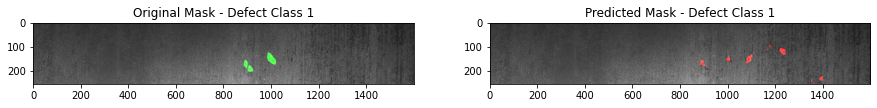

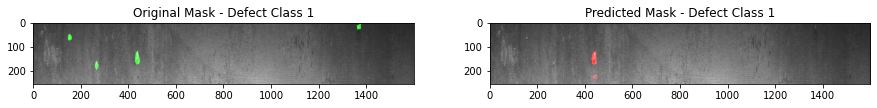

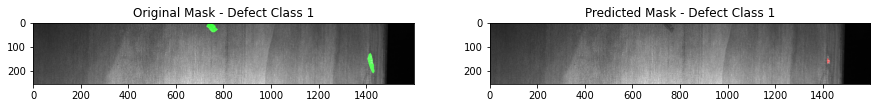

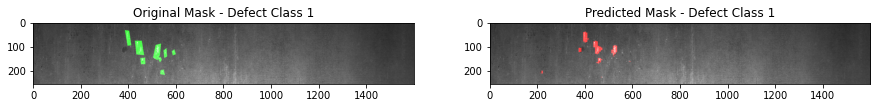

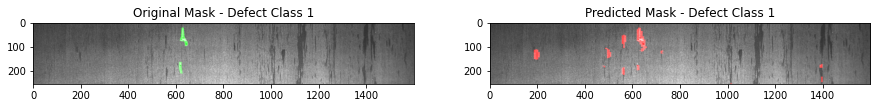

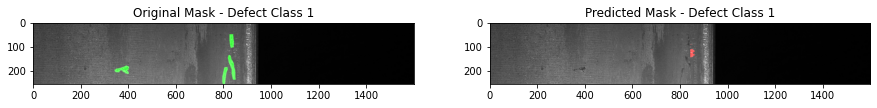

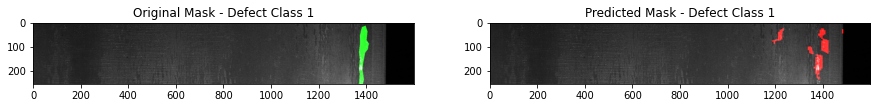

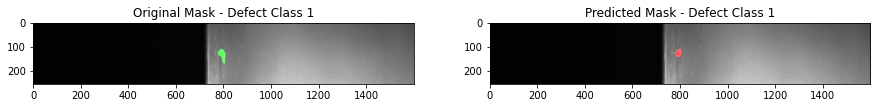

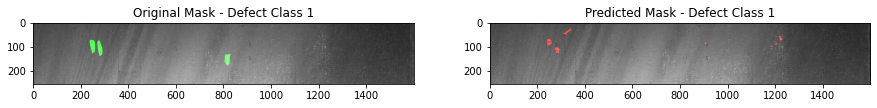

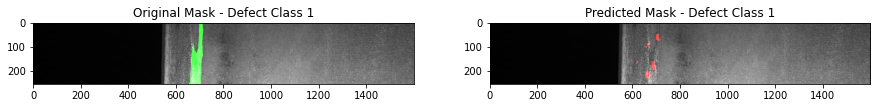

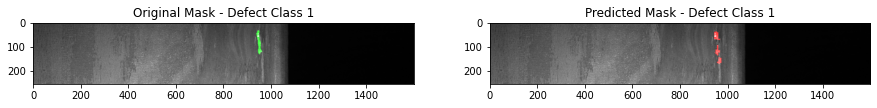

In [62]:
show_original_pred_mask(images_path = TRAINING_IMAGES, X_test= X_test, df_pred=df_pred_1, no_of_images_to_print=10)

## Class 2 images training

In [137]:
# Training, test and validations sets
X_train, X_test, X_val = get_X_train_test_val(DF_TRAIN, class_id=2)

Number of images in train data :  190
Number of images in test data :  30
Number of images in validation data :  27


In [138]:
# Model training 
model_c2, history_c2 = training(X_train =X_train,
                                X_val=X_val,
                                images_dir_path=TRAINING_IMAGES,
                                weights_save_path=SEGMENTATION_MODEL_C2_PATH,
                                earlystopping_patience= SEGMENTATION_MODEL_C2_PATIENCE,
                                lr= 0.001,
                                epochs= SEGMENTATION_MODEL_C2_EPOCH)

Epoch 1/30
11/11 [==============================] - 9s 404ms/step - loss: 0.9928 - dice_coef: 0.0072 - val_loss: 0.9924 - val_dice_coef: 0.0076

Epoch 00001: val_loss improved from inf to 0.99244, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_2_segmentation/ResUNet-segmentation-weights_class_2.hdf5
Epoch 2/30
11/11 [==============================] - 3s 310ms/step - loss: 0.9906 - dice_coef: 0.0094 - val_loss: 0.9913 - val_dice_coef: 0.0087

Epoch 00002: val_loss improved from 0.99244 to 0.99129, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_2_segmentation/ResUNet-segmentation-weights_class_2.hdf5
Epoch 3/30
11/11 [==============================] - 4s 314ms/step - loss: 0.9890 - dice_coef: 0.0110 - val_loss: 0.9913 - val_dice_coef: 0.0087

Epoch 00003: val_loss did not improve from 0.99129
Epoch 4/30
11/11 [==============================] - 3s 309ms/step - loss: 0.9874 - dice_coef: 0.0126 - val_loss: 0.9918 - 

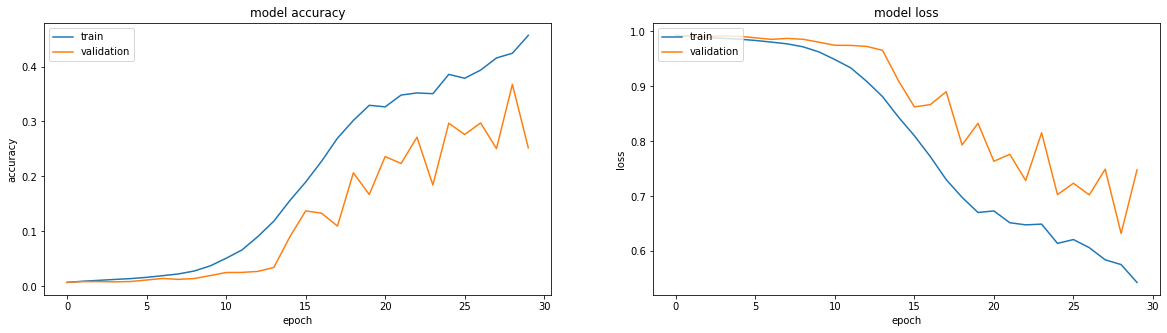

In [139]:
get_history_plot(history_c2, 'dice_coef')

In [140]:
X_test.reset_index(inplace=True)
# get prediction
image_id, defect_type, mask = predict_mask(X_test, model_c2, TRAINING_IMAGES)
# create a dataframe of the predictions
df_pred_2= pd.DataFrame({'ImageId': image_id,'ClassId': defect_type,'EncodedPixels': mask})
df_pred_2.head()

,ImageId,ClassId,EncodedPixels
0,5ca7fcc19.jpg,2,120952 34 121008 18 121208 34 121264 18 121464...
1,72bb7c7bc.jpg,2,141592 2 141596 52 141848 2 141852 52 142104 2...
2,447038bc8.jpg,2,132148 51 132208 8 132221 2 132243 17 132404 5...
3,739a0aa20.jpg,2,10505 157 10665 67 10741 5 10761 157 10921 67 ...
4,41f5ea1f2.jpg,2,229822 12 229838 6 229846 8 229858 8 230078 12...


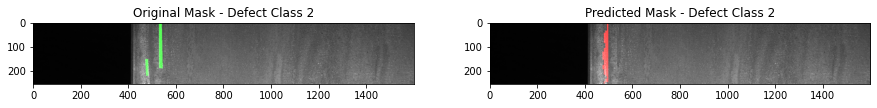

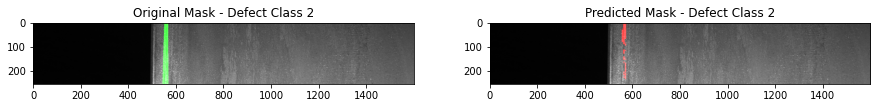

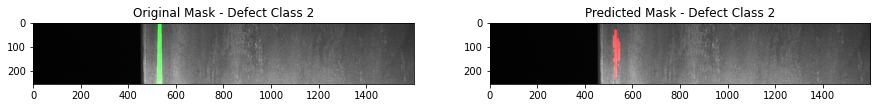

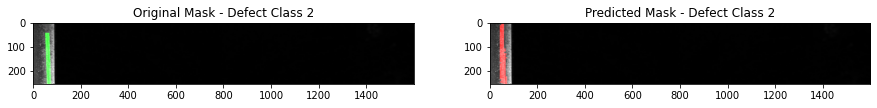

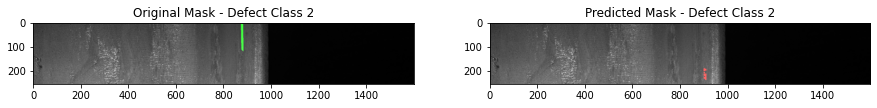

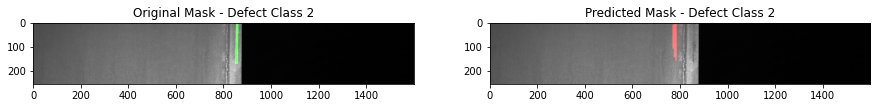

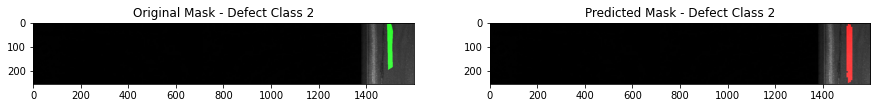

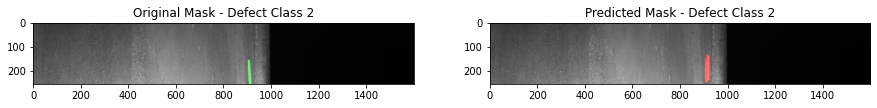

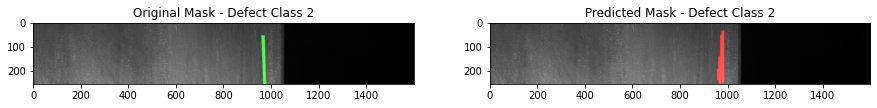

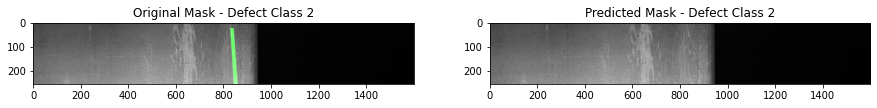

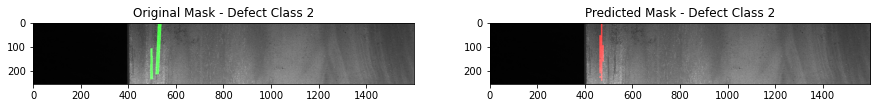

In [141]:
show_original_pred_mask(images_path = TRAINING_IMAGES, X_test= X_test, df_pred=df_pred_2, no_of_images_to_print=10)

## Class 3 images training

In [99]:
# Training, test and validations sets
X_train, X_test, X_val = get_X_train_test_val(DF_TRAIN, class_id=3)

Number of images in train data :  3988
Number of images in test data :  618
Number of images in validation data :  544


In [100]:
# Model training 
model_c3, history_c3 = training(X_train =X_train,
                                X_val=X_val,
                                images_dir_path=TRAINING_IMAGES,
                                weights_save_path=SEGMENTATION_MODEL_C3_PATH,
                                earlystopping_patience= SEGMENTATION_MODEL_C3_PATIENCE,
                                lr= 0.001,
                                epochs= SEGMENTATION_MODEL_C3_EPOCH)

Epoch 1/12
249/249 [==============================] - 87s 333ms/step - loss: 0.7862 - dice_coef: 0.2138 - val_loss: 0.7074 - val_dice_coef: 0.2926

Epoch 00001: val_loss improved from inf to 0.70737, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_3_segmentation/ResUNet-segmentation-weights_class_3.hdf5
Epoch 2/12
249/249 [==============================] - 83s 332ms/step - loss: 0.4838 - dice_coef: 0.5162 - val_loss: 0.4863 - val_dice_coef: 0.5137

Epoch 00002: val_loss improved from 0.70737 to 0.48630, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_3_segmentation/ResUNet-segmentation-weights_class_3.hdf5
Epoch 3/12
249/249 [==============================] - 82s 327ms/step - loss: 0.4482 - dice_coef: 0.5518 - val_loss: 0.4534 - val_dice_coef: 0.5466

Epoch 00003: val_loss improved from 0.48630 to 0.45343, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_3_segmentation/ResUNet-

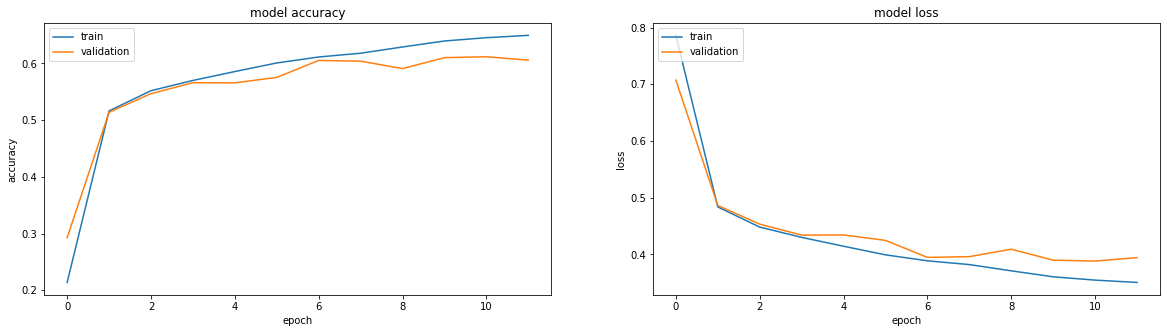

In [101]:
get_history_plot(history_c3, 'dice_coef')

In [102]:
X_test.reset_index(inplace=True)
# get prediction
image_id, defect_type, mask = predict_mask(X_test, model_c3, TRAINING_IMAGES)
# create a dataframe of the predictions
df_pred_3= pd.DataFrame({'ImageId': image_id,'ClassId': defect_type,'EncodedPixels': mask})
df_pred_3.head()

,ImageId,ClassId,EncodedPixels
0,b0e0b8842.jpg,3,57071 3 57327 3 57583 3 57839 3 58095 3 58351 ...
1,b3f7ae992.jpg,3,290305 36 290356 1 290363 1 290561 36 290612 1...
2,a8fcfff62.jpg,3,26377 3 26406 3 26633 3 26662 3 26889 3 26918 ...
3,a8f977b31.jpg,3,162367 1 162380 3 162385 1 162393 5 162430 11 ...
4,b12e436c3.jpg,3,92079 3 92087 1 92335 3 92343 1 92591 3 92599 ...


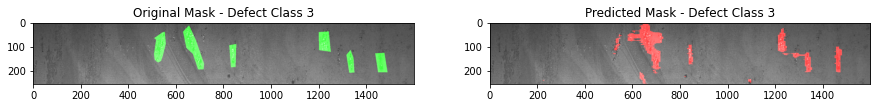

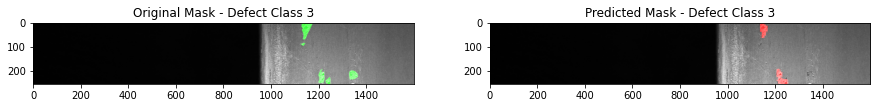

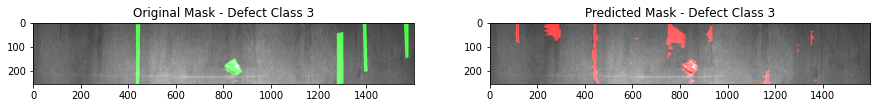

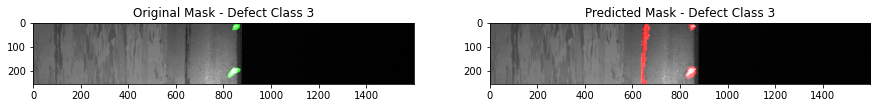

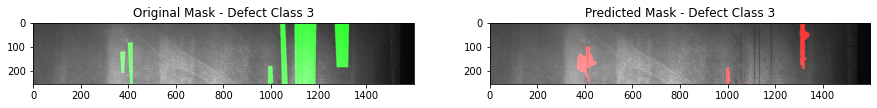

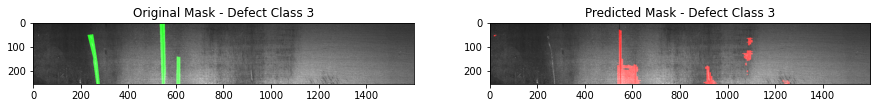

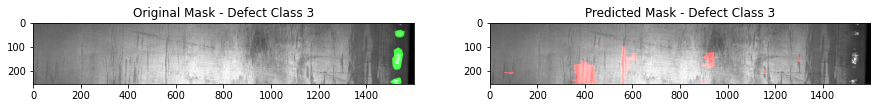

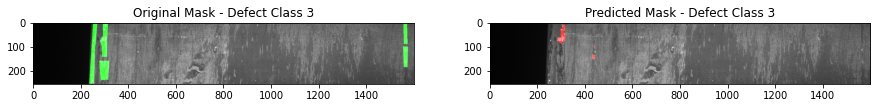

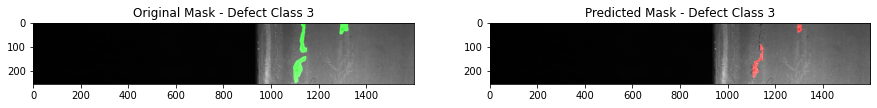

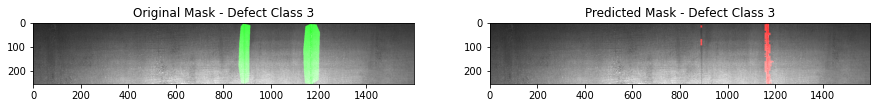

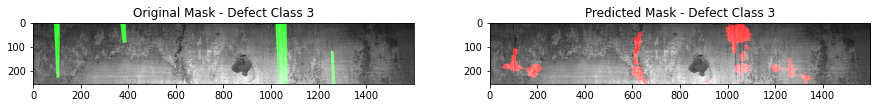

In [103]:
show_original_pred_mask(images_path = TRAINING_IMAGES, X_test= X_test, df_pred=df_pred_3, no_of_images_to_print=10)

## Class 4 images training

In [89]:
# Training, test and validations sets
X_train, X_test, X_val = get_X_train_test_val(DF_TRAIN, class_id= 4)

Number of images in train data :  619
Number of images in test data :  97
Number of images in validation data :  85


In [90]:
# Model training 
model_c4, history_c4 = training(X_train =X_train,
                                X_val=X_val,
                                images_dir_path=TRAINING_IMAGES,
                                weights_save_path=SEGMENTATION_MODEL_C4_PATH,
                                earlystopping_patience = SEGMENTATION_MODEL_C4_PATIENCE,
                                lr= 0.001,
                                epochs= SEGMENTATION_MODEL_C4_EPOCH)

Epoch 1/8
38/38 [==============================] - 17s 366ms/step - loss: 0.9219 - dice_coef: 0.0781 - val_loss: 0.9433 - val_dice_coef: 0.0567

Epoch 00001: val_loss improved from inf to 0.94332, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_4_segmentation/ResUNet-segmentation-weights_class_4.hdf5
Epoch 2/8
38/38 [==============================] - 13s 339ms/step - loss: 0.8916 - dice_coef: 0.1084 - val_loss: 0.9137 - val_dice_coef: 0.0863

Epoch 00002: val_loss improved from 0.94332 to 0.91365, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_4_segmentation/ResUNet-segmentation-weights_class_4.hdf5
Epoch 3/8
38/38 [==============================] - 13s 342ms/step - loss: 0.8519 - dice_coef: 0.1481 - val_loss: 0.8868 - val_dice_coef: 0.1132

Epoch 00003: val_loss improved from 0.91365 to 0.88676, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/class_4_segmentation/ResUNet-segmentat

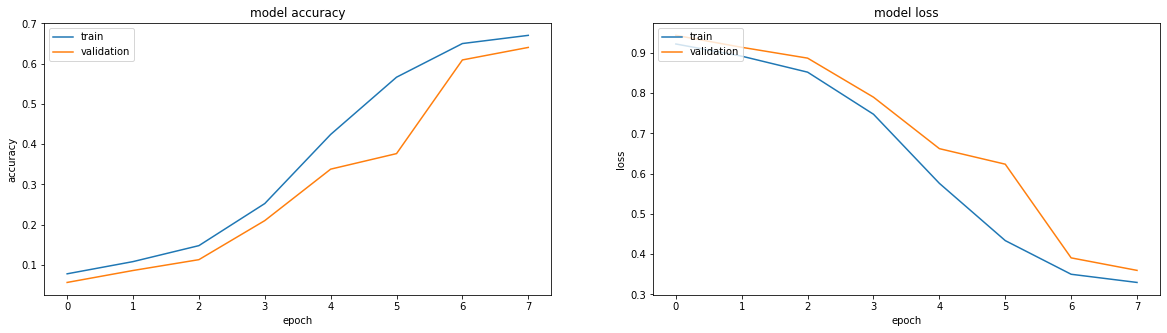

In [91]:
get_history_plot(history_c4, 'dice_coef')

In [92]:
X_test.reset_index(inplace=True)
# get prediction
image_id, defect_type, mask = predict_mask(X_test, model_c4, TRAINING_IMAGES)
# create a dataframe of the predictions
df_pred_4= pd.DataFrame({'ImageId': image_id,'ClassId': defect_type,'EncodedPixels': mask})
df_pred_4.head()

,ImageId,ClassId,EncodedPixels
0,01afbfa7a.jpg,4,269680 2 269936 2 270192 2 270448 2 270704 2 2...
1,53e812ced.jpg,4,196242 30 196273 37 196498 30 196529 37 196754...
2,1e742caeb.jpg,4,23488 5 23744 5 24000 5 24256 5 24512 5 24768 ...
3,84865746c.jpg,4,180080 50 180152 12 180336 50 180408 12 180592...
4,03db6bbc3.jpg,4,45808 3 46064 3 46320 3 46576 3 46832 3 47088 ...


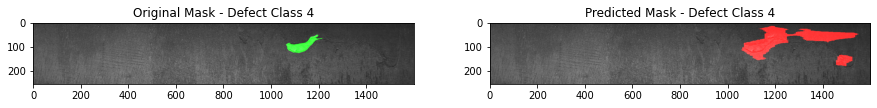

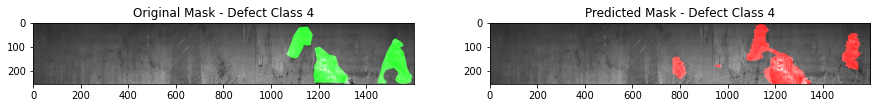

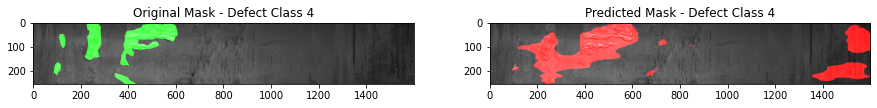

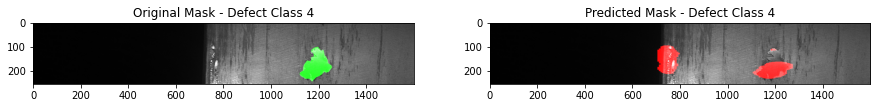

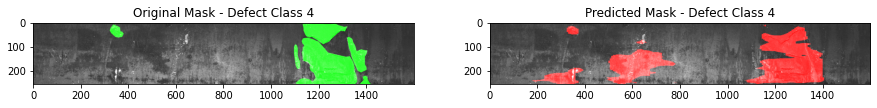

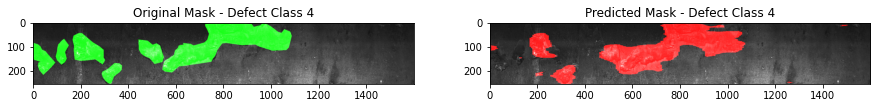

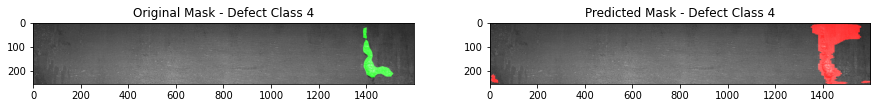

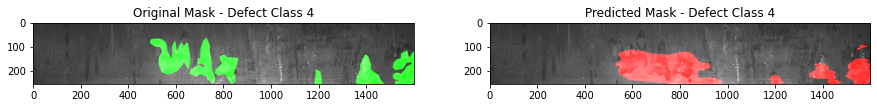

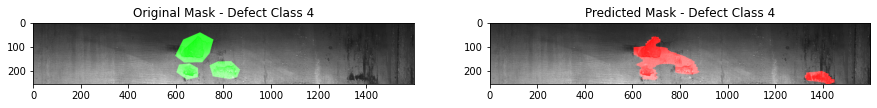

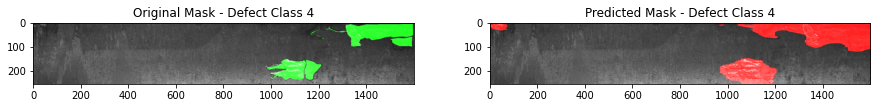

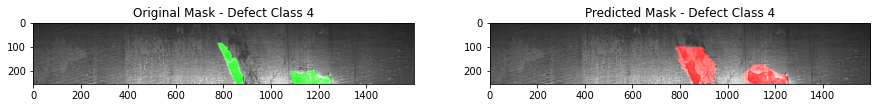

In [93]:
show_original_pred_mask(images_path = TRAINING_IMAGES, X_test= X_test, df_pred=df_pred_4, no_of_images_to_print=10)

# Final Prediction

In [143]:
# Loading saved models
model_seg_c1 = load_model(model_path=SEGMENTATION_MODEL_C1_PATH)
model_seg_c2 = load_model(model_path=SEGMENTATION_MODEL_C2_PATH)
model_seg_c3 = load_model(model_path=SEGMENTATION_MODEL_C3_PATH)
model_seg_c4 = load_model(model_path=SEGMENTATION_MODEL_C4_PATH)

In [144]:
def defect_preprocessing(path):
  #reading the image
  img = io.imread(path)

  #Normalizing the image
  img = img * 1./255.

  #Reshaping the image
  img = cv2.resize(img,(256,256))

  #Converting the image into array
  img = np.array(img, dtype = np.float64)

  #reshaping the image from 256,256,3 to 1,256,256,3
  img = np.reshape(img, (1,256,256,3))
  
  return img

In [145]:
def predict_defect_type(img, model):
  #making prediction on the image
  preds = model.predict(img)
  preds=np.argmax(preds, axis=1)
  if preds==1:
    preds='Defect_1'
  elif preds==2:
      preds="Defect_2"
  elif preds==3:
      preds="Defect_3"
  elif preds==4:
      preds="Defect_4"
  else:
      preds="No_Defect"      
  return preds

In [146]:
def segmentation_preprocessing(path):
  #reading the image again along blue channel (0)
  img = io.imread(path)
  img =img[:,:,0]  

  #Creating a empty array of shape 1,256,256,1
  X = np.empty((1, 256, 256, 1))

  #resizing the image and coverting them to array of type float64
  img = cv2.resize(img,(256,256))
  img = np.array(img, dtype = np.float64)

  #standardising the image
  img -= img.mean()
  img /= img.std()

  #converting the shape of image from 256,256 to 1,256,256,1
  X[0,] = np.expand_dims(img, axis = 2)

  return X, img

In [147]:
def get_pred_rle(img, mask_value):
  
  #applying mask to image, area with defect will be highlighted in white(255)
  img[mask_value == 1] = 255

  #since original shape is 256,1600, reshape to that size
  img = cv2.resize(img,(1600,256))

  #Now, mask the image such that, areas which are not white(defected areas) to be black(0)
  img[img < 255] = 0

  #again normalize the values
  img = img * 1./255.

  #get the rle for the create masked image
  rle = mask2rle(img)
  return rle

In [150]:
def prediction(X_test, model_clf, model_seg_c1, model_seg_c2, model_seg_c3,model_seg_c4, images_path):
  
  mask = []
  defect_type = []
  image_id = []

  #iterating through each image in the test data
  for i in X_test.ImageId:
    path = os.path.join(images_path, i)

    #image preprocessing
    img = defect_preprocessing(path=path)
    pred_defect = predict_defect_type(img, model_clf)
    if pred_defect == 'Defect_1':
      X, img = segmentation_preprocessing(path=path)
      #make prediction
      predict = model_seg_c1.predict(X)
      mask_value = predict[0,:,:,0].round().astype(int)
      rle = get_pred_rle(img=img, mask_value=mask_value)
      # print('Class_1 defect - YES !')
      mask.append(rle)
      defect_type.append(1)
      image_id.append(i)
      continue

    elif pred_defect == 'Defect_2':
      X, img = segmentation_preprocessing(path=path)
      #make prediction
      predict = model_seg_c2.predict(X)
      mask_value = predict[0,:,:,1].round().astype(int)
      rle = get_pred_rle(img=img, mask_value=mask_value)
      # print('Class_2 defect - YES !')
      mask.append(rle)
      defect_type.append(2)
      image_id.append(i)
      continue

    elif pred_defect == 'Defect_3':
      X, img = segmentation_preprocessing(path=path)
      #make prediction
      predict = model_seg_c3.predict(X)
      mask_value = predict[0,:,:,2].round().astype(int)
      rle = get_pred_rle(img=img, mask_value=mask_value)
      # print('Class_3 defect - YES !')
      mask.append(rle)
      defect_type.append(3)
      image_id.append(i)
      continue

    elif pred_defect == 'Defect_4':
      X, img = segmentation_preprocessing(path=path)
      #make prediction
      predict = model_seg_c4.predict(X)
      mask_value = predict[0,:,:,3].round().astype(int)
      rle = get_pred_rle(img=img, mask_value=mask_value)
      # print('Class_4 defect - YES !')
      mask.append(rle)
      defect_type.append(4)
      image_id.append(i)
      continue
    
    else: 
      image_id.append(i)
      # append no defect 
      defect_type.append(0)
      # No defect == no mask
      mask.append('0 0')    
      # print('No defect!')
      continue
  
  df_pred = pd.DataFrame({'ImageId': image_id,'ClassId' : defect_type,'EncodedPixels': mask})
  return df_pred

In [176]:
# Reading test images dataframe
DF_TEST = pd.read_csv(DIR+'test.csv')

In [178]:
%time
# Prediction on test images
df_pred_multimodel = prediction(DF_TEST.head(50), model_clf, model_seg_c1, model_seg_c2, model_seg_c3,model_seg_c4, TEST_IMAGES)
df_pred_multimodel.head()

CPU times: user 0 ns, sys: 8 µs, total: 8 µs
Wall time: 15.3 µs


,ImageId,ClassId,EncodedPixels
0,ccd4bb323.jpg,1,47279 8 47535 8 47791 8 48047 8 48303 8 48559 ...
1,d01da361f.jpg,1,360713 14 360969 14 361225 14 361481 14 361737...
2,d3122844c.jpg,1,285912 4 285926 13 286168 4 286182 13 286424 4...
3,d5fab51f7.jpg,0,0 0
4,cfe180664.jpg,1,65008 16 65264 16 65520 16 65776 16 66032 16 6...


In [182]:
def show_predicted_mask(images_path, X_test, df_pred, no_of_images_to_print):

  for i in range(no_of_images_to_print+1):
    img0 = io.imread(os.path.join(images_path, X_test['ImageId'][i]))
    img1 = io.imread(os.path.join(images_path, df_pred['ImageId'][i]))
    #converting images from BGR(openCV default) to RGB
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    # getting mask from the encodings
    mask1 = rle2mask(rle = df_pred['EncodedPixels'][i], height= img1.shape[0], width= img1.shape[1])
    # making the mask red
    img1[mask1 == 1,0] = 255
    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plt.imshow(img0)
    plt.title('Original Iamge')
    plt.subplot(122)
    plt.imshow(img1)
    plt.title('Predicted Mask - Defect Class %s' % df_pred['ClassId'][i])
    plt.show()

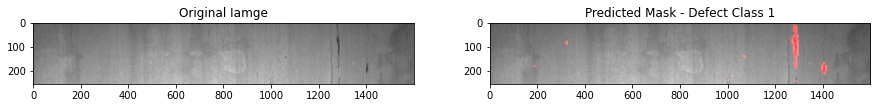

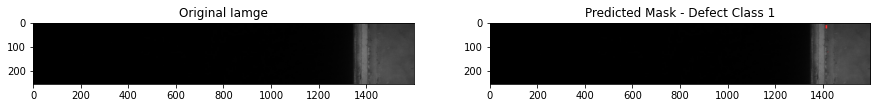

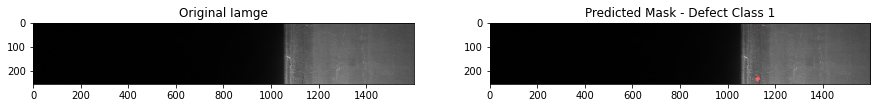

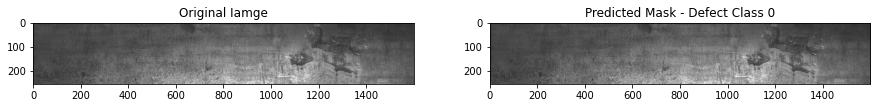

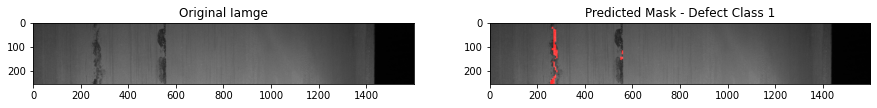

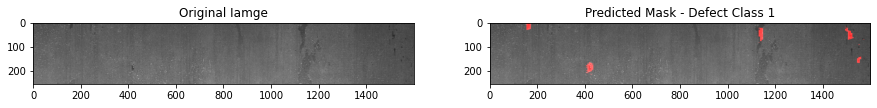

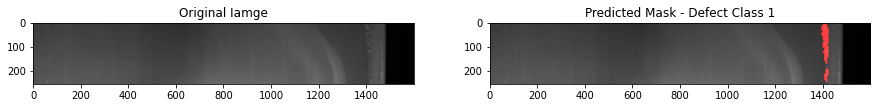

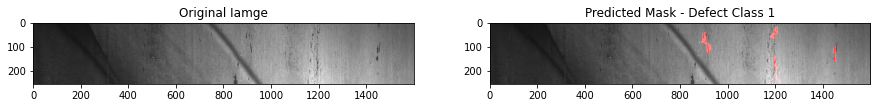

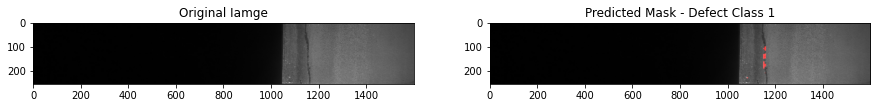

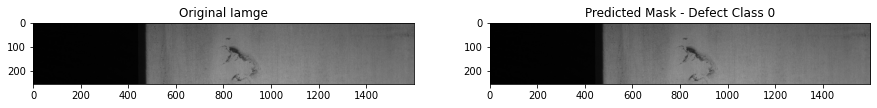

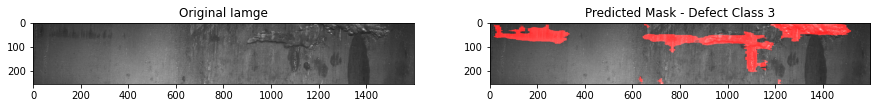

In [185]:
show_original_pred_mask_test(TEST_IMAGES, DF_TEST.head(50), df_pred_multimodel, 10)

**Observation :**

* Model having hard time classifying for Defect 2 and Defect 4 images. This is probably due to the low recall and f1-score of classification model for minority classes

* *Scope of improvement :* Classification model can further be improved by repeating augmented images of minority classes (Defect 1,2 & 4)